# Connect to google drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [3]:
! pip install pymongo

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pymongo import MongoClient



# Connect to mongo

In [5]:

MONGO_CONNECTION_STRING = "YOUR_MONGO_CONNECTION_STRING"

client = MongoClient(MONGO_CONNECTION_STRING)
db = client['T5Bootcamp']
drivers_coll = db['state_distracted_driver_detection']


# Data collection

## Run this cell if you have the data as "zip" file

In [8]:
# The dataset exists as "zip" file, here we are unzipping it.
# It contains: images and labels
!unzip "/content/drive/MyDrive/Colab Notebooks/T5 - Bootcamp/data/dataset_new.zip"

Streaming output truncated to the last 5000 lines.
  inflating: images/image_2797.npy   
  inflating: images/image_0485.npy   
  inflating: images/image_3722.npy   
  inflating: images/image_0669.npy   
  inflating: images/image_1130.npy   
  inflating: images/image_2078.npy   
  inflating: images/image_1570.npy   
  inflating: images/image_0341.npy   
  inflating: images/image_5631.npy   
  inflating: images/image_5357.npy   
  inflating: images/image_5726.npy   
  inflating: images/image_1805.npy   
  inflating: images/image_4705.npy   
  inflating: images/image_5508.npy   
  inflating: images/image_5707.npy   
  inflating: images/image_0534.npy   
  inflating: images/image_5875.npy   
  inflating: images/image_3910.npy   
  inflating: images/image_4493.npy   
  inflating: images/image_5150.npy   
  inflating: images/image_1269.npy   
  inflating: images/image_0847.npy   
  inflating: images/image_0569.npy   
  inflating: images/image_1797.npy   
  inflating: images/image_2874.npy   

In [9]:
def load_sorted_images_and_labels(npy_folder, label_file_path):

    # List all .npy files and sort them to match the order of labels
    npy_files = [f for f in os.listdir(npy_folder) if f.endswith('.npy')]
    npy_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[1]))

    # Load images in the sorted order
    X = [np.load(os.path.join(npy_folder, file)) for file in npy_files]
    X = np.array(X)

    # Load labels and convert them to integers
    with open(label_file_path, 'r') as file:
        labels = [int(label.strip()) for label in file.readlines()]
    y = np.array(labels)

    return X, y

# Paths
npy_folder = '/content/images'
label_file_path = '/content/labels.txt'

# Load images and labels
X, y = load_sorted_images_and_labels(npy_folder, label_file_path)

print(f"Loaded {len(X)} images into X with shape {X.shape}.")
print(f"Loaded {len(y)} labels into y with sample labels: {y[:5]}")


Loaded 6000 images into X with shape (6000, 180, 90, 3).
Loaded 6000 labels into y with sample labels: [1 0 1 0 0]


### Store the images in database for later access (Only 5 will be stored)


In [32]:
# Prepare the data to be inserted
documents = []


# We are only saving the first 5 images since the total images are huge to be stored in the database
for i in range(len(X[:5])):

    image = np.array(X[i], dtype=np.float32).ravel().tobytes()

    document = {
        "image": image,
        "label": int(y[i])
    }
    documents.append(document)

# Insert all documents at once
drivers_coll.insert_many(documents)


InsertManyResult([ObjectId('66bf65378e3c715c77c33792'), ObjectId('66bf65378e3c715c77c33793'), ObjectId('66bf65378e3c715c77c33794'), ObjectId('66bf65378e3c715c77c33795'), ObjectId('66bf65378e3c715c77c33796')], acknowledged=True)

## Run this cell if you already have the dataset stored in database (Only 5 will be retrieved)

In [57]:
# Retrieve documents from the collection

documents = drivers_coll.find()

# Reconstruct the images and labels
X_loaded = []
y_loaded = []


for doc in documents:
    X_loaded.append(np.frombuffer(doc['image'], dtype=np.float32).reshape(180, 90, 3))
    y_loaded.append(doc['label'])

X_loaded = np.array(X_loaded)
y_loaded = np.array(y_loaded)

print(f"Loaded {X_loaded.shape[0]} images with shape {X_loaded.shape[1:]}")
print(f"Loaded labels with shape: {y_loaded.shape}")

Loaded 5 images with shape (180, 90, 3)
Loaded labels with shape: (5,)


#### Plot a random image that retieved from the database

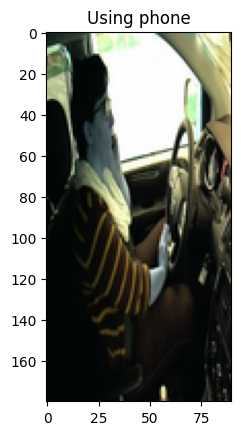

In [69]:
import random

index = random.randint(0,4)


plt.title("Using phone" if y_loaded[index] == 1 else "Not using phone")
plt.imshow(X_loaded[index])

# Preprocessing

In [ ]:
y.shape

(6000,)

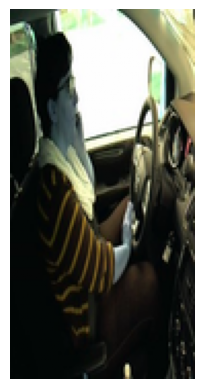

In [70]:
# Display the image
plt.imshow(X[0])
plt.axis('off')
plt.show()

In [71]:
# Split the dataset into train and test
# The train dataset will be used to split the train and validation dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1)

In [72]:
print(X_train.shape)
print(X_validation.shape)


(4320, 180, 90, 3)
(480, 180, 90, 3)


# Model selection

In [74]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])), # (90, 180, 3)
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


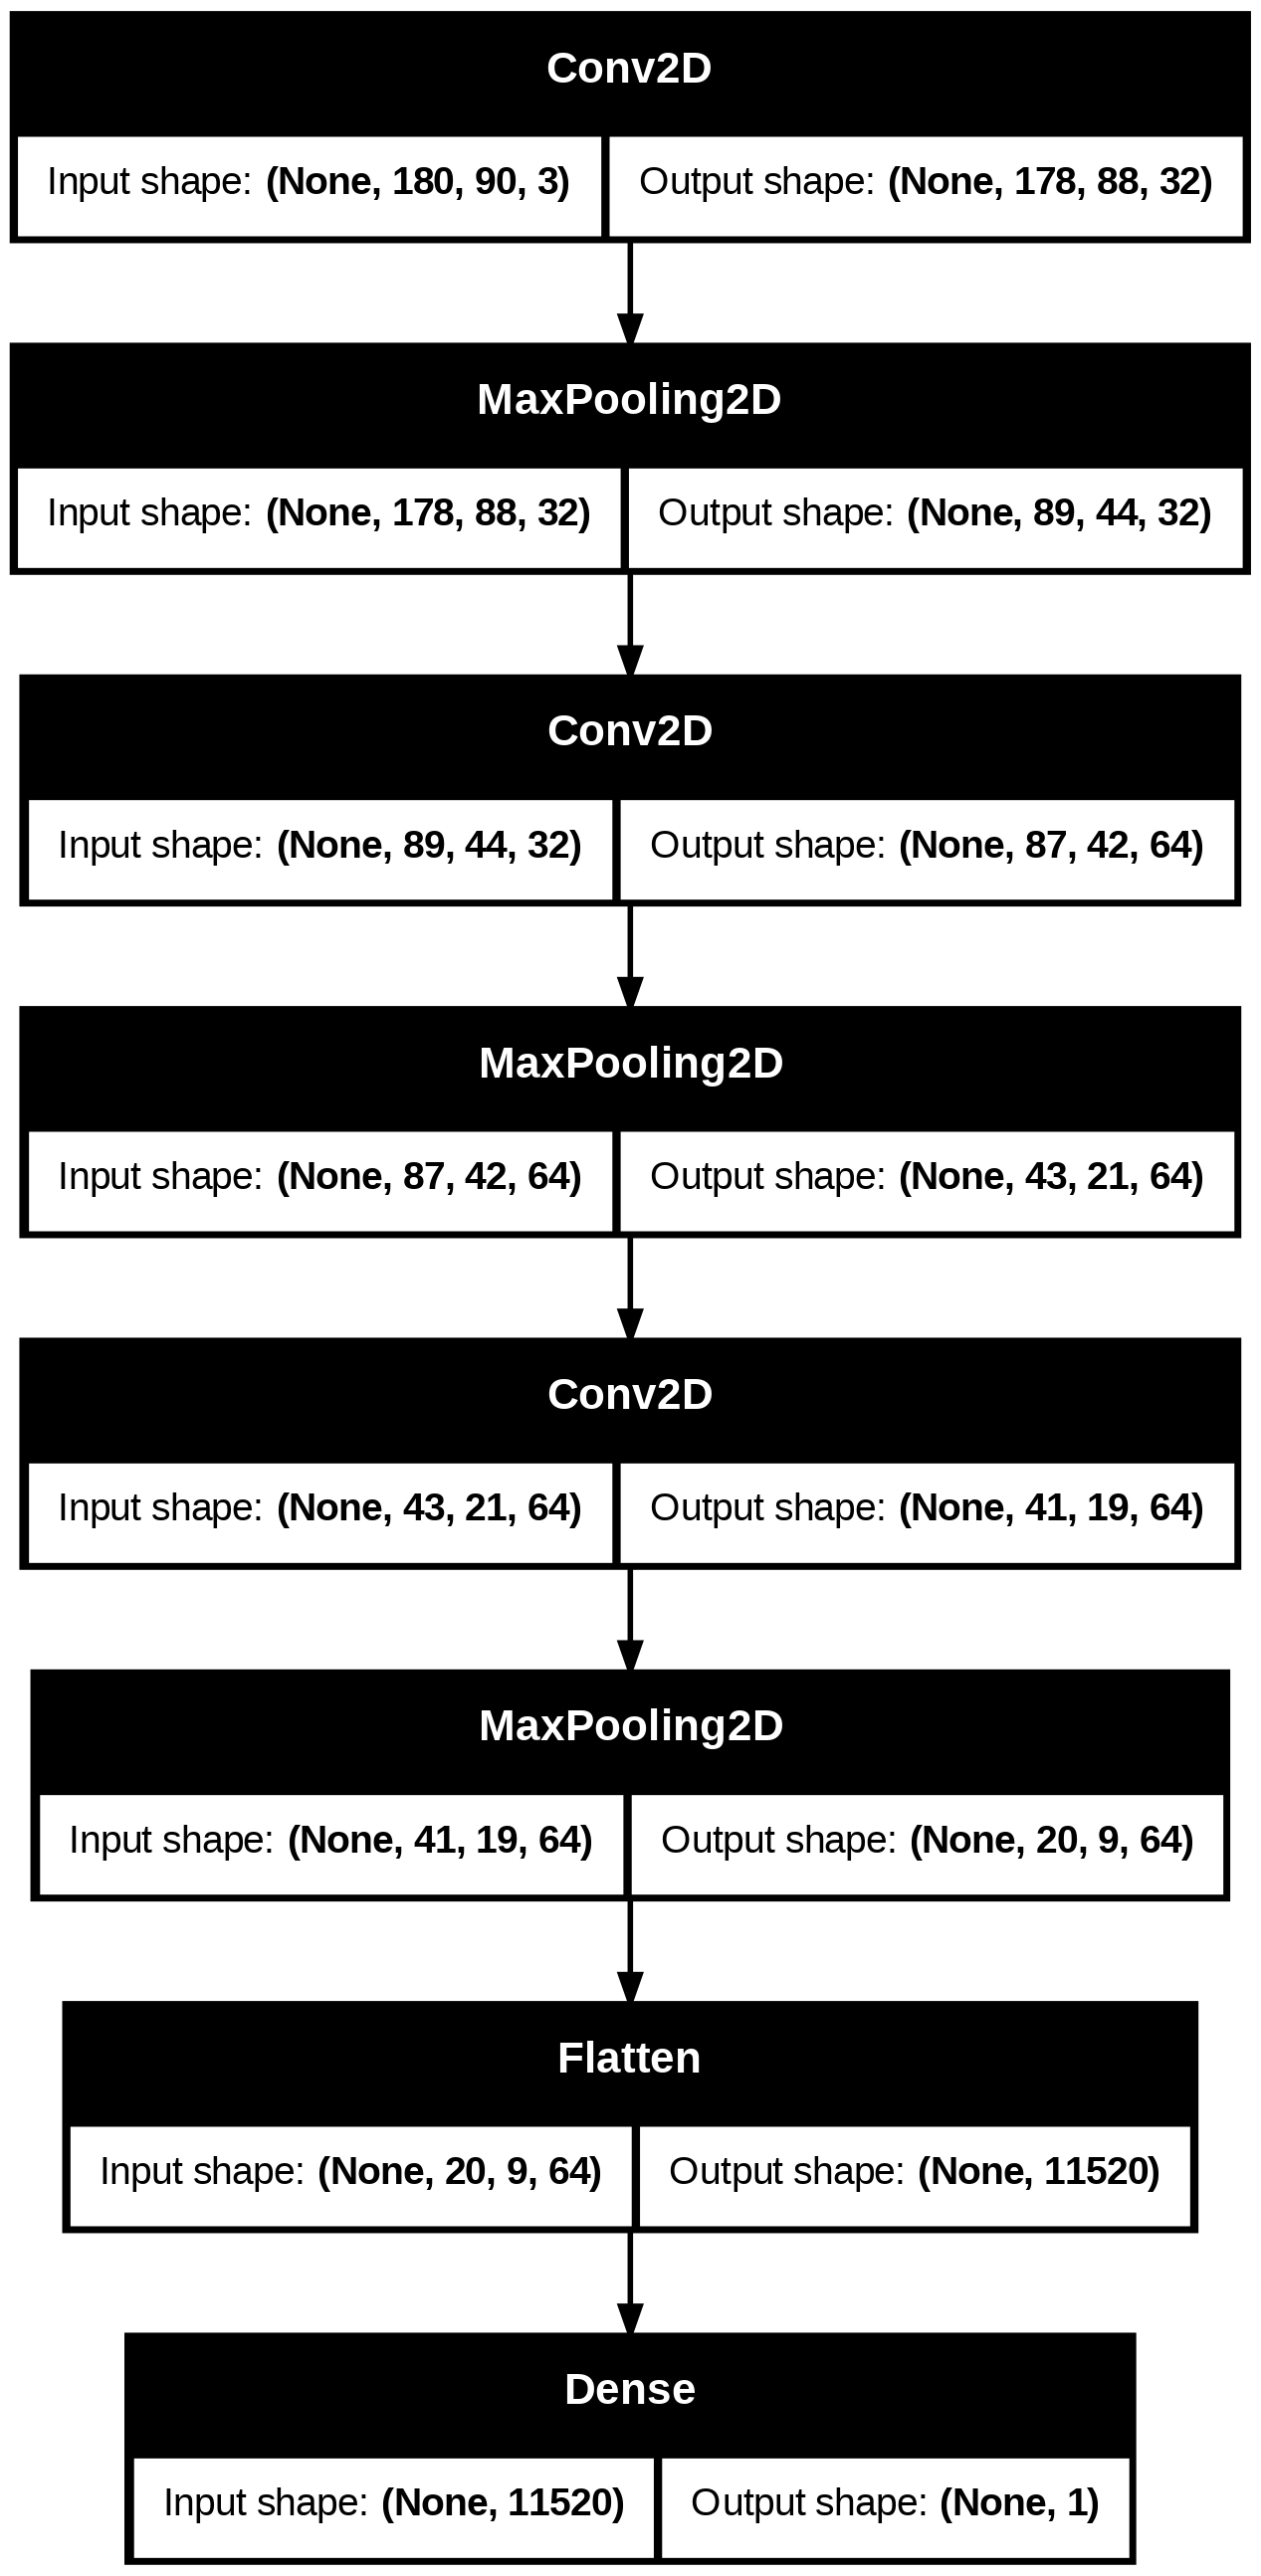

In [ ]:
tf.keras.utils.plot_model(model, "CNN.png", show_shapes=True)

# Implementation

# Training

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_validation, y_validation))

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 136s 995ms/step - accuracy: 0.6336 - loss: 0.6307 - val_accuracy: 0.8813 - val_loss: 0.2843
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9220 - loss: 0.2037 - val_accuracy: 0.9521 - val_loss: 0.1109
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9756 - loss: 0.0719 - val_accuracy: 0.9792 - val_loss: 0.0591
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 137s 983ms/step - accuracy: 0.9861 - loss: 0.0322 - val_accuracy: 0.9833 - val_loss: 0.0455
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9948 - loss: 0.0183 - val_accuracy: 0.9875 - val_loss: 0.0340
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9964 - loss: 0.0151 - val_accuracy: 0.9896 - val_loss: 0.0264
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9971 - loss: 0.0090 - val_accuracy: 0.9896 - val_loss: 0.0353
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 136s 971ms/step - accuracy: 0.9930 - loss: 0.0215 -

# Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 532ms/step - accuracy: 0.9844 - loss: 0.0503
Test accuracy: 0.9800000190734863


In [ ]:
predictions = model.predict(X_test)


38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 343ms/step


In [ ]:
threshold = 0.5
predicted_classes = (predictions > threshold).astype(int)

print(predicted_classes)

[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]


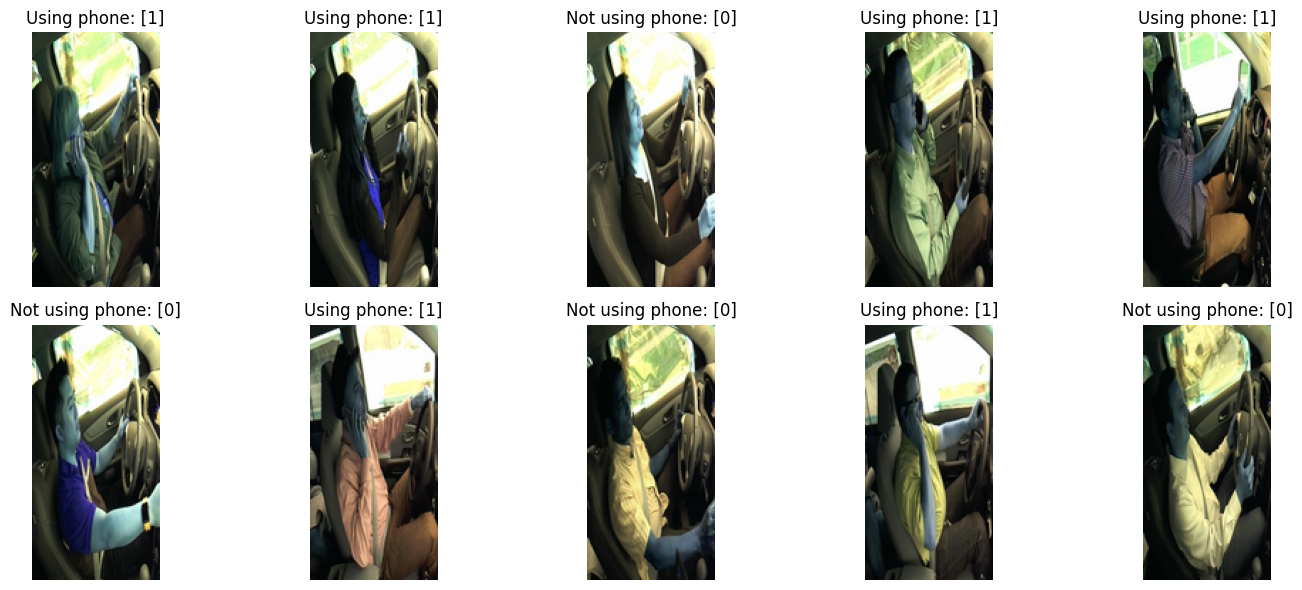

In [ ]:
import random

random_nums = [random.randint(1, 500) for _ in range(10)]

rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

axes = axes.flatten()


# Loop through the random indices and display images
for i, ax in zip(random_nums, axes):
    ax.imshow(X_test[i])
    ax.axis('off')  # Hide axis
    ax.set_title(f"{'Using phone' if predicted_classes[i] == 1 else 'Not using phone'}: {predicted_classes[i]}")

plt.tight_layout()
plt.show()